### Models

#### Model Options
- Linear Regression (or Kernelized Regression)
  - KernelDensity(kernel='linear')
- K-Nearest Neighbors
  - KernelDensity()
- Gaussian Processes
  - KernelDensity(kernel='gaussian')
- Neural Networks
- Random Forest Regressor
- Adaptive or Gradient Boosting Regressor
- "linear", "gaussian", 

In [32]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [33]:
data = "../data/train.csv"
df = pd.read_csv(data)

In [34]:
# extract the features & target variable from the dataframe

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
    # alt method: y = df['target']


#### Data Exploration: Target 

In [35]:
y.head()

stats_df = y.describe()
stats_df.loc['range'] = [float(stats_df.loc['max']) - float(stats_df.loc['min'])]
# ["count", "mean", "std", "min", "q1", "q2", "q3", "max"]

stats_df

,target
count,8250.000000
mean,0.867212
std,0.405036
min,-0.000000
25%,0.600000
50%,0.800000
75%,1.100000
max,3.500000
range,3.500000


In [36]:
# compute basic descriptive statistics for the target variable
mean = np.mean(y)
median = np.median(y)
std_dev = np.std(y)
min_val = np.min(y)
max_val = np.max(y)
y_range = max_val - min_val

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)
print("Range:", y_range)


Mean: target    0.867212
dtype: float64
Median: 0.8
Standard Deviation: target    0.405011
dtype: float64
Minimum Value: target   -0.0
dtype: float64
Maximum Value: target    3.5
dtype: float64
Range: target    3.5
dtype: float64


/Users/eleanorbrock/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/eleanorbrock/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/eleanorbrock/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkw

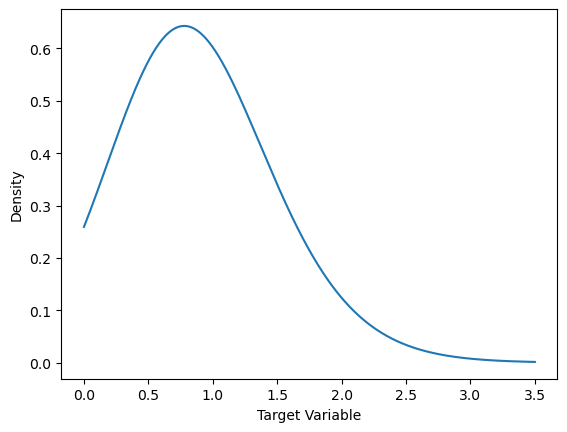

In [37]:
# create a kernel density estimate of the target's distribution
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(y.to_numpy().reshape(-1,1))

# create a set of x-values at which to evaluate the KDE
x_vals = np.linspace(min_val, max_val, 1000).reshape(-1,1)

# get the corresponding y-values by evaluating the KDE at the x-values 
y_vals = np.exp(kde.score_samples(x_vals))

# plot the KDE
plt.plot(x_vals, y_vals)
plt.xlabel('Target Variable')
plt.ylabel('Density')
plt.show()

# Alternative methods
# sns.displot(y, kind="kde")
# sns.kdeplot(y)

#### kde for all features

In [39]:
n,d = np.shape(X.to_numpy())
fig = plt.figure(figsize=(20,10))
for i in range(d):
    # create a kernel density estimate of the target's distribution
    temp = X.iloc[:,i].to_numpy().reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(temp)

    # create a set of x-values at which to evaluate the KDE
    x_vals = np.linspace(np.min(temp), np.max(temp), 1000).reshape(-1,1)

    # get the corresponding y-values by evaluating the KDE at the x-values 
    y_vals = np.exp(kde.score_samples(x_vals))

    # plot the KDE
    axes = fig.add_subplot(4,10,i+1)
    axes.plot(x_vals, y_vals)
    plt.title('feature ' + str(i+1))
    plt.subplots_adjust(wspace=0.75,hspace=0.5)
plt.show()

TypeError: 'Series' object is not callable

<Figure size 2000x1000 with 0 Axes>

#### Data Exploration: Features

In [40]:
X.head()

feat_df = X.describe()

range_list = []
for each in feat_df.columns:
    range_list.append(float(feat_df[each]['max']) - float(feat_df[each]['min']))

feat_df.loc['range'] = range_list
feat_df


,acc_rate,track,m,n,current_pitch,current_roll,absoluate_roll,climb_delta,roll_rate_delta,climb_delta_diff,...,time7_delta,time8_delta,time9_delta,time10_delta,time11_delta,time12_delta,time13_delta,time14_delta,omega,set
count,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,...,8250.000000,8.250000e+03,8250.000000,8.250000e+03,8250.000000,8.250000e+03,8250.000000,8250.000000,8250.000000,8250.000000
mean,-11.526061,-12.672970,1.051280,0.060387,0.629371,0.061248,-11.004848,-0.920364,-0.000957,-0.047842,...,-0.000018,-1.212121e-07,-0.000099,4.848485e-07,8.999901,-7.272727e-07,-0.000093,-10.000001,-0.510279,0.021982
std,259.637258,25.675733,0.320703,0.118805,0.313628,0.967274,4.140399,10.334136,0.013203,1.132179,...,0.000113,1.100964e-05,0.000615,6.963359e-05,0.000631,6.030154e-05,0.000613,0.000037,0.257113,0.006961
min,-975.000000,-95.000000,0.216536,-0.530000,-0.420000,-3.000000,-23.000000,-44.000000,-0.080000,-8.800000,...,-0.001000,-1.000000e-03,-0.006000,-2.000000e-03,8.995000,-4.000000e-03,-0.005000,-10.003000,-0.916291,0.012000
25%,-175.000000,-29.000000,0.802519,-0.020000,0.430000,-0.600000,-14.000000,-8.000000,-0.009000,-0.300000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,9.000000,0.000000e+00,0.000000,-10.000000,-0.693147,0.018000
50%,-23.000000,-13.000000,1.020201,0.060000,0.610000,0.200000,-11.000000,-1.000000,-0.001000,-0.100000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,9.000000,0.000000e+00,0.000000,-10.000000,-0.510826,0.020000
75%,157.000000,3.000000,1.258600,0.130000,0.800000,0.700000,-7.000000,6.000000,0.008000,0.200000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,9.000000,0.000000e+00,0.000000,-10.000000,-0.356675,0.023000
max,946.000000,94.000000,2.886371,0.620000,2.580000,2.900000,-3.000000,46.000000,0.056000,8.700000,...,0.000600,0.000000e+00,0.003000,6.000000e-03,9.005000,2.000000e-03,0.007000,-10.000000,0.693147,0.073000
range,1921.000000,189.000000,2.669835,1.150000,3.000000,5.900000,20.000000,90.000000,0.136000,17.500000,...,0.001600,1.000000e-03,0.009000,8.000000e-03,0.010000,6.000000e-03,0.012000,0.003000,1.609438,0.061000


In [41]:
NOTDROP = [11, 12, 14]
drop = []
feat_df = X.describe()

for i, a in enumerate(feat_df.columns):


    if i not in NOTDROP:
        drop.append(a)

feat_df = feat_df.drop(columns=drop)
feat_df

,time2,time3,time5
count,8250.000000,8250.000000,8250.000000
mean,0.021886,0.021886,0.021898
std,0.006906,0.006906,0.006914
min,0.012000,0.012000,0.012000
25%,0.018000,0.018000,0.018000
50%,0.020000,0.020000,0.020000
75%,0.023000,0.023000,0.023000
max,0.078000,0.078000,0.078000


In [42]:
feature_list = X.columns.values.tolist()

# for each in feature_list:
    
    # same procedure as with target --- for each feature

# Alternative methods?
# sns.displot(y, kind="kde")
# sns.kdeplot(y)
# sns.displot(X, kind="kde")
mean = np.mean(X,axis=0)
median = np.median(X,axis=0)
std_dev = np.std(X,axis=0)
min_val = np.min(X,axis=0)
max_val = np.max(X,axis=0)
range = max_val - min_val

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)
print("Range:", range)

Mean: acc_rate           -1.152606e+01
track              -1.267297e+01
m                   1.051280e+00
n                   6.038667e-02
current_pitch       6.293709e-01
current_roll        6.124848e-02
absoluate_roll     -1.100485e+01
climb_delta        -9.203636e-01
roll_rate_delta    -9.567273e-04
climb_delta_diff   -4.784242e-02
time1               2.187236e-02
time2               2.188558e-02
time3               2.188558e-02
time4               2.189782e-02
time5               2.189794e-02
time6               2.191770e-02
time7               2.191818e-02
time8               2.193745e-02
time9               2.193745e-02
time10              2.195418e-02
time11              4.390739e-02
time12              2.196885e-02
time13              2.196921e-02
time14              2.198194e-02
time1_delta        -1.320000e-04
time2_delta        -1.212121e-07
time3_delta        -6.266667e-05
time4_delta        -3.636364e-07
time5_delta        -8.072727e-05
time6_delta        -7.272727e-07
time

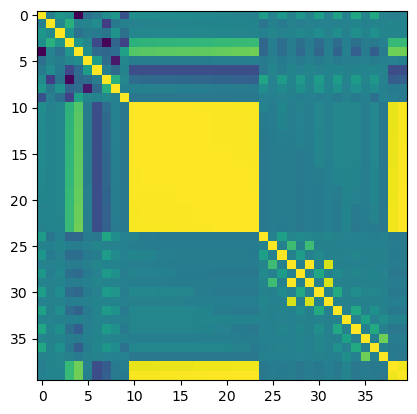

In [43]:
# cov matrix for 40 features
cov = np.corrcoef(X.T)
plt.imshow(cov)
plt.show()

In [44]:
temp = np.argsort(correlation)
print(temp)


# milestone 2 temp argsort of corr matrix


NameError: name 'correlation' is not defined

In [45]:
# scatter plot for three most correlated feature and target
correlation = np.corrcoef(df.T)[:-1, -1]
# print(correlation[6])
print(correlation)
temp = np.argsort(correlation)
print(temp)



# milestone 2 correlations, raw sorted


[ 0.0796419  -0.06128885  0.33442014  0.39697445  0.30807996  0.1060146
 -0.70451479 -0.05697029 -0.05277419 -0.07356026  0.641312    0.64040464
  0.64040464  0.64039829  0.64041334  0.63881696  0.63882888  0.63637387
  0.63637387  0.6335669   0.63370708  0.63081227  0.63076117  0.62833479
  0.03530695 -0.0090469   0.01661653 -0.01943319  0.01064093 -0.01943319
  0.03211506 -0.01720246  0.04020203 -0.00287484  0.0273297  -0.00891783
  0.0258262  -0.02429623  0.61592022  0.62827199]
[ 6  9  1  7  8 37 27 29 31 25 35 33 28 26 36 34 30 24 32  0  5  4  2  3
 38 39 23 22 21 19 20 18 17 15 16 13 12 11 14 10]


In [46]:
print(sorted(np.abs(correlation)))
av_temp = np.argsort(np.abs(correlation))
av_temp

# milestone 2 correlations, sorted as absolute values

# print(sorted(np.abs(correlation))) -->
    # [0.0028748441628541196, 0.008917829140455929, 0.009046901236544894, 0.010640925795167918, 0.016616528910079073, 
    # 0.01720245780563928, 0.019433185595649907, 0.019433185595649907, 0.024296226752424478, 0.02582620430133633, 
    # 0.027329701051732613, 0.03211506117122077, 0.035306950332327856, 0.04020203378759955, 0.05277418814161673, 
    # 0.056970294145277905, 0.061288852660047966, 0.07356026312089133, 0.07964190054974578, 0.10601459861929727, 
    # 0.3080799621532908, 0.33442013907309565, 0.3969744453356405, 0.6159202211674142, 0.6282719851321911, 
    # 0.6283347894625325, 0.6307611698740028, 0.6308122682088417, 0.6335668974934873, 0.6337070768152011, 
    # 0.636373872247207, 0.636373872247207, 0.6388169578630334, 0.6388288800726142, 0.6403982947247882, 
    # 0.6404046428202611, 0.6404046428202611, 0.6404133411853217, 0.6413120025165505, 0.7045147870681108]


[0.0028748441628541196, 0.008917829140455929, 0.009046901236544894, 0.010640925795167918, 0.016616528910079073, 0.01720245780563928, 0.019433185595649907, 0.019433185595649907, 0.024296226752424478, 0.02582620430133633, 0.027329701051732613, 0.03211506117122077, 0.035306950332327856, 0.04020203378759955, 0.05277418814161673, 0.056970294145277905, 0.061288852660047966, 0.07356026312089133, 0.07964190054974578, 0.10601459861929727, 0.3080799621532908, 0.33442013907309565, 0.3969744453356405, 0.6159202211674142, 0.6282719851321911, 0.6283347894625325, 0.6307611698740028, 0.6308122682088417, 0.6335668974934873, 0.6337070768152011, 0.636373872247207, 0.636373872247207, 0.6388169578630334, 0.6388288800726142, 0.6403982947247882, 0.6404046428202611, 0.6404046428202611, 0.6404133411853217, 0.6413120025165505, 0.7045147870681108]


array([33, 35, 25, 28, 26, 31, 27, 29, 37, 36, 34, 30, 24, 32,  8,  7,  1,
        9,  0,  5,  4,  2,  3, 38, 39, 23, 22, 21, 19, 20, 18, 17, 15, 16,
       13, 12, 11, 14, 10,  6])

ValueError: num must be an integer with 1 <= num <= 4, not 5

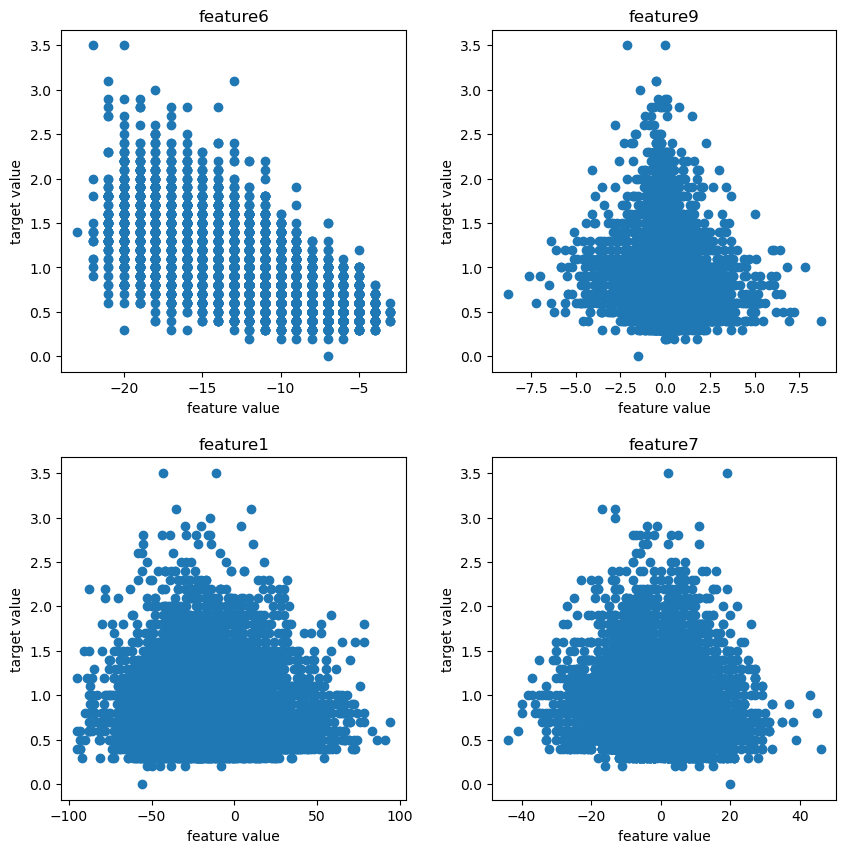

In [47]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
for i, n in enumerate(temp):
    feature = X.iloc[:, n]
    plt.subplot(2, 2, i+1)
    plt.title('feature' + str(n))
    plt.scatter(feature, y)
    plt.xlabel('feature value')
    plt.ylabel('target value')
plt.show()

ValueError: num must be an integer with 1 <= num <= 16, not 17

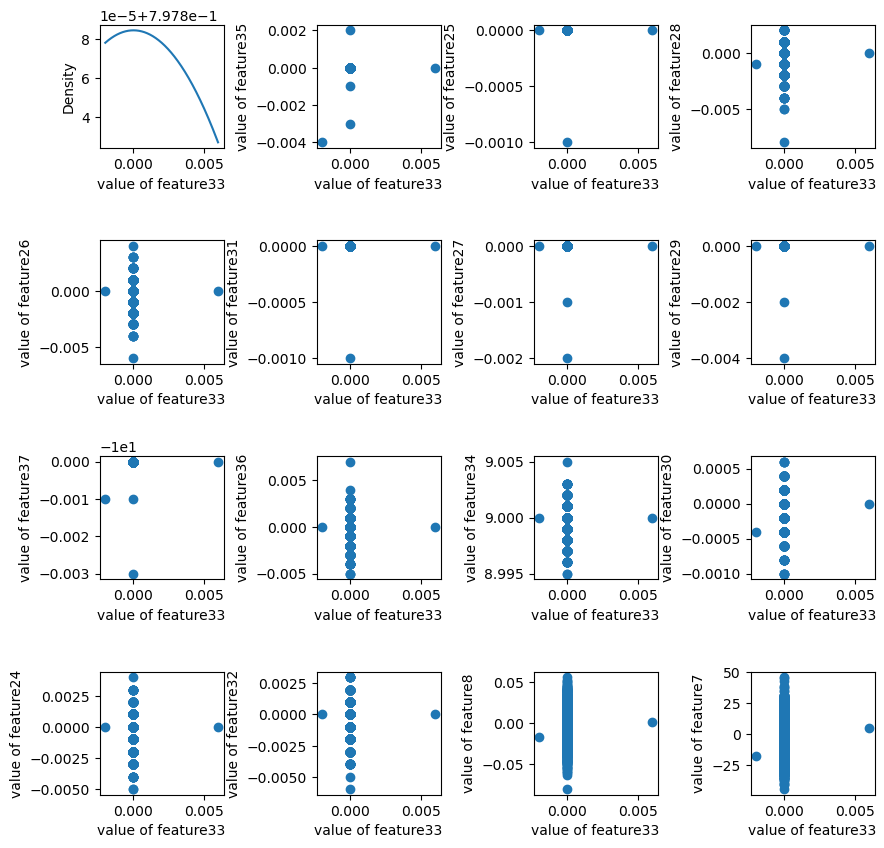

In [48]:
# choose a feature and find three most correlated feature, for example, 28 
# 33 35 25
# correlation = cov[:, [33,35,25]]
correlation = cov[:, 28]
temp = sorted(np.argsort(correlation)[-4:])

plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.75,hspace=0.75)
for i, temp1 in enumerate(av_temp):
    for j, temp2 in enumerate(av_temp):
        feature1 = X.iloc[:, temp1]
        feature2 = X.iloc[:, temp2]
        if i == j:
            kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(feature1.to_numpy().reshape(-1, 1))
            # create a set of x-values at which to evaluate the KDE
            x_vals = np.linspace(np.min(feature1), np.max(feature2), 1000).reshape(-1, 1)
            # get the corresponding y-values by evaluating the KDE at the x-values
            y_vals = np.exp(kde.score_samples(x_vals))
            plt.subplot(4, 4, 4*i+j+1)

            plt.plot(x_vals, y_vals)
            plt.xlabel('value of feature' + str(temp1))
            plt.ylabel('Density')
        else:
            plt.subplot(4, 4, 4*i+j+1)
            plt.scatter(feature1, feature2)
            plt.xlabel('value of feature' + str(temp1))
            plt.ylabel('value of feature' + str(temp2))
plt.show()

## Baseline Models

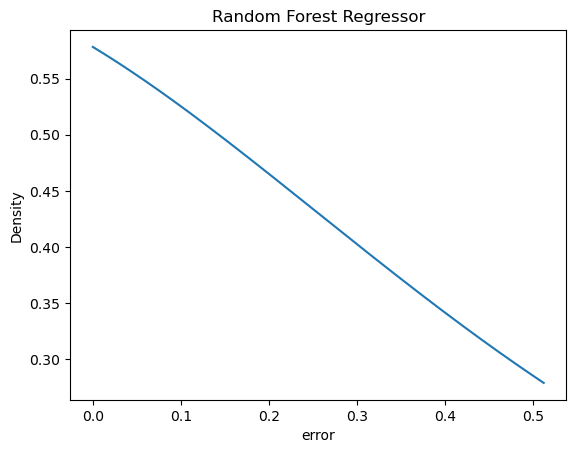

Random Forest Regressor in sample error: 0.005347982491582492
Random Forest Regressor out sample error: 0.02936704242424243


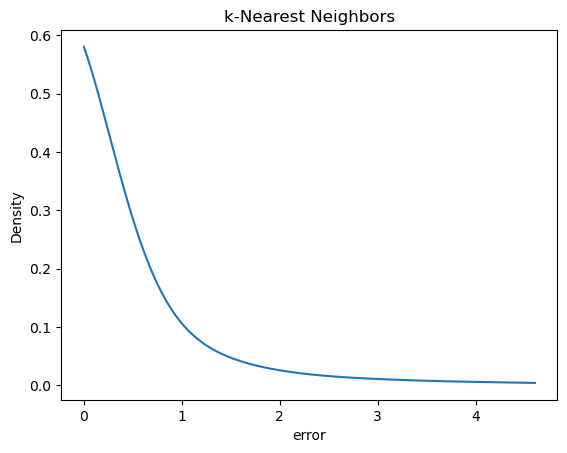

k-Nearest Neighbors in sample error: 0.07570949494949494
k-Nearest Neighbors out sample error: 0.1290675


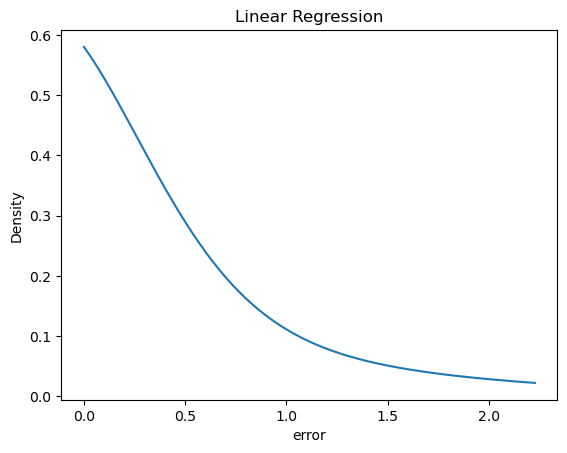

Linear Regression in sample error: 0.02956366217726798
Linear Regression out sample error: 0.030187214565511628
in sample t-Test
Random Forest Regressor and k-Nearest Neighbors TtestResult(statistic=-197.56736356106933, pvalue=1.1092370950227326e-17, df=9)
Random Forest Regressor and Linear Regression TtestResult(statistic=-319.2013171579582, pvalue=1.4795574433881626e-19, df=9)
k-Nearest Neighbors and Linear Regression TtestResult(statistic=137.36921550755497, pvalue=2.9175540344320846e-16, df=9)
out sample t-Test
Random Forest Regressor and knn TtestResult(statistic=-24.088554273174644, pvalue=1.7507583715003322e-09, df=9)
Random Forest Regressor and Linear Regression TtestResult(statistic=-1.5522671518922189, pvalue=0.1550145808857905, df=9)
k-Nearest Neighbors and Linear Regression TtestResult(statistic=24.815079035140784, pvalue=1.3447716953652279e-09, df=9)


In [49]:
# random forest regressor
kf = KFold(n_splits=10)
random_forest_regressor = RandomForestRegressor(n_estimators=10)
kng = KNeighborsRegressor(n_neighbors=4)
models = [('Random Forest Regressor', random_forest_regressor), ('k-Nearest Neighbors', kng),('Linear Regression', LinearRegression())]
in_sample_error = []
out_sample_error = []
for name, model in models:
    in_sample_err = []
    out_sample_err = []
    mse=[]
    for train, test in kf.split(X):
        model.fit(X.iloc[train], np.ravel(y.iloc[train]))
        model.fit(X.iloc[train], np.ravel(y.iloc[train]))
        predict_train = model.predict(X.iloc[train])
        predict_test = model.predict(X.iloc[test])
        predict = model.predict(X)
        mse.append((np.ravel(predict) - np.ravel(y))**2) 
        in_sample_err.append(MSE(predict_train, y.iloc[train]))
        out_sample_err.append(MSE(predict_test, y.iloc[test]))
    in_sample_error.append(in_sample_err)
    out_sample_error.append(out_sample_err)
    error = np.mean(mse, axis=0)
    zscore = (error-np.mean(error))/np.std(error)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(zscore.reshape(-1,1))
    # create a set of x-values at which to evaluate the KDE
    x_vals = np.linspace(np.min(error), np.max(error), 1000).reshape(-1,1)
    # get the corresponding y-values by evaluating the KDE at the x-values 
    y_vals = np.exp(kde.score_samples(x_vals))
    # plot the KDE
    plt.title(name)
    plt.plot(x_vals, y_vals)
    plt.xlabel('error')
    plt.ylabel('Density')
    plt.show()
    print(name,'in sample error:',np.mean(in_sample_err))
    print(name,'out sample error:',np.mean(out_sample_err))
print('in sample t-Test')
print('Random Forest Regressor and k-Nearest Neighbors',stats.ttest_rel(in_sample_error[0], in_sample_error[1]))
print('Random Forest Regressor and Linear Regression',stats.ttest_rel(in_sample_error[0], in_sample_error[2]))
print('k-Nearest Neighbors and Linear Regression',stats.ttest_rel(in_sample_error[1], in_sample_error[2]))
print('out sample t-Test')
print('Random Forest Regressor and knn',stats.ttest_rel(out_sample_error[0], out_sample_error[1]))
print('Random Forest Regressor and Linear Regression',stats.ttest_rel(out_sample_error[0], out_sample_error[2]))
print('k-Nearest Neighbors and Linear Regression',stats.ttest_rel(out_sample_error[1], out_sample_error[2]))

In [ ]:
# kde for z-score error for each model

## Milestone 2

In [50]:
from sklearn.preprocessing import StandardScaler, normalize

In [51]:
df.isna().values.any()

False

In [52]:
new_df = df.to_numpy()
new_df
demo_var = StandardScaler().fit(new_df)
demo_var.scale_

new_df.std()

40.951701378014036

In [53]:
# from sklearn.preprocessing import normalize
# import numpy as np

# Create sample data
# X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Normalize the data using L2 normalization
X_normalized = normalize(new_df, norm='l2')


In [54]:
X_normalized

array([[-7.41091322e-01,  5.25935777e-01,  2.69541333e-02, ...,
         8.04376305e-03,  1.19530858e-03,  3.34686403e-02],
       [ 9.69525054e-01, -2.09627039e-01,  7.14526923e-03, ...,
        -3.63255977e-03,  8.38508155e-05,  2.62033798e-03],
       [ 9.89854642e-01, -9.89854642e-02,  4.62631044e-03, ...,
        -5.33526256e-03,  1.04808139e-04,  2.91133718e-03],
       ...,
       [ 9.95693740e-01, -8.32056050e-03,  2.36343798e-03, ...,
        -1.41678517e-03,  6.65644840e-05,  2.21881613e-03],
       [ 9.98877541e-01,  2.51606433e-03,  2.29950966e-03, ...,
        -1.74400290e-03,  4.52891580e-05,  2.26445790e-03],
       [ 9.98867496e-01, -1.09967064e-02,  2.60084486e-03, ...,
        -6.53708272e-04,  4.21540411e-05,  2.74917659e-03]])

#### Normalize 

In [55]:
data = "../data/train.csv"
df = pd.read_csv(data)
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1:].to_numpy()
# standardize X
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [56]:
# random forest regressor
kf = KFold(n_splits=10)
model = RandomForestRegressor(n_estimators=10)
training_set = [(X,y),(X_std,y)]
in_sample_error = []
out_sample_error = []
for set_X, set_y in training_set:
    in_sample_err = []
    out_sample_err = []
    for train, test in kf.split(X):
        model.fit(set_X[train], np.ravel(set_y[train]))
        model.fit(set_X[train], np.ravel(set_y[train]))
        predict_train = model.predict(set_X[train])
        predict_test = model.predict(set_X[test])
        in_sample_err.append(MSE(predict_train, set_y[train]))
        out_sample_err.append(MSE(predict_test, set_y[test]))
    in_sample_error.append(in_sample_err)
    out_sample_error.append(out_sample_err)

    print('in sample error:',np.mean(in_sample_err))
    print('out sample error:',np.mean(out_sample_err))
print(out_sample_error[0])
print(out_sample_error[1])
print('in sample t-Test')
print(stats.ttest_rel(in_sample_error[0], in_sample_error[1]))

print('out sample t-Test')
print(stats.ttest_rel(out_sample_error[0], out_sample_error[1]))

in sample error: 0.005359896296296296
out sample error: 0.030027903030303026
in sample error: 0.0053100592592592605
out sample error: 0.029563236363636364
[0.029974545454545455, 0.02916993939393939, 0.029182303030303034, 0.029107030303030305, 0.029581696969696966, 0.028495393939393942, 0.031043757575757582, 0.031503030303030304, 0.029724848484848486, 0.032496484848484844]
[0.02774072727272727, 0.030990787878787878, 0.030147151515151516, 0.028004242424242425, 0.02868424242424242, 0.02849442424242424, 0.0295230303030303, 0.03149515151515152, 0.029225333333333336, 0.031327272727272724]
in sample t-Test
TtestResult(statistic=1.200189350094905, pvalue=0.2607032407229809, df=9)
out sample t-Test
TtestResult(statistic=1.2213030721867322, pvalue=0.2529977702738549, df=9)


#### Clustering (10 pts)

Notice that in the previous section, we are simply selecting from the features we are given. However, in feature engineering, we may create new features from our insight into the data. One method we'll look at is k-means clustering.

- Perform k-means clustering on the data with all features, using k = 2
``
- Plot a scatter plot of your result, where each axis corresponds to the points' distance from the cluster centers, and the points use either size, shape, or color to illustrate the target value.
`sns.scatterplot(data=__, x=___, y=___)`
- Use a linear regression model to predict target, using the distances from cluster centers as your features. Was the clustering informative? Explain why it is or is not.
- Try different values of k and recluster, using the resulting features as predictors in a linear regression model. Larger k means more features, which should result in better predictions, but it can also result in unnecessarily complex predictor models and overfitting to the training data. How would you pick the most informative k? Decide how you could use this information in terms of feature engineering your data, and explain your decision.



In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [78]:
# Perform k-means clustering with k=2
# which dataset variable to use? im not entirely clear
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit_transform(X,y)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

/Users/eleanorbrock/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


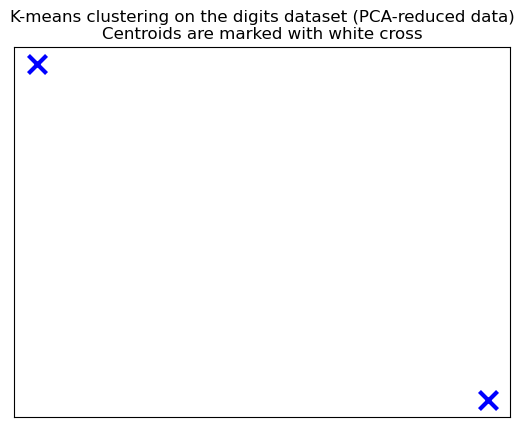

In [80]:
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="b",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with blue cross"
)
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


In [73]:

# Set aside target value column for colorizing the plot
# target = df.iloc[:,-1:]

# sns.scatterplot(x=distances[:, 0], y=distances[:, 1])
# Plot a scatter plot of the distances with the target value as the color of the points
# sns.scatterplot(x=distances, y=distances[:, 1], hue=target, palette='Set2')
# plt.xlabel('Distance from cluster center 1')
# plt.ylabel('Distance from cluster center 2')
# plt.show()


#### PCA (10 pts)
Now we'll look at another method in feature engineering, Principal Component Analysis(PCA).

- Perform PCA, keeping two components. Then, plot a 3d scatter plot where the x, y axes correspond to the two components and the z axis corresponds to the target variable. Interpret this plot.
- Perform PCA for the following number of components: 10, 20, 30, 40.
- Choose one model that you used from Milestone 1. For each PCA-transformed version of the dataset, perform k cross-validation on the data with the model. Compare the performances between each version and the original standardized dataset.


/Users/eleanorbrock/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


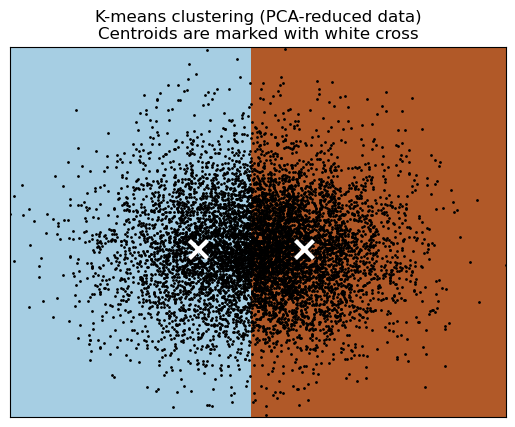

In [82]:

reduced_data = PCA(n_components=2).fit_transform(df)
# kmeans = KMeans(init="k-means++", n_clusters=4, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


In [74]:
# PCA(n_components=2).fit(X_normalized)


# n_components_list = [10,20,30,40]


PCA(n_components=2)